In [41]:
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv
import os
import math

In [42]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [43]:
imgs_dir = '/content/drive/My Drive/images/'
imgs_file = [img for img in os.listdir(imgs_dir)]
imgs = [cv.imread(os.path.join(imgs_dir, img), cv.IMREAD_COLOR) for img in imgs_file]
imgs.pop() # pop the last elem since it's not an img

array([[[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       ...,

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]]], dtype=uint8)
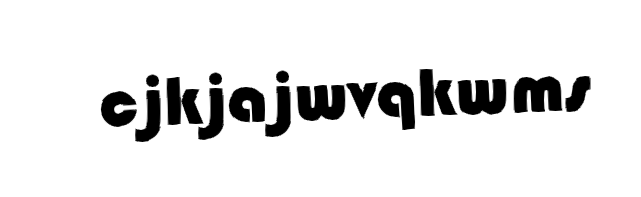

In [44]:
imgs[0]

# First try

First, each image is converted into a **binary** image. This simplifies the detection process by reducing the data to just two colors.

In [45]:
# Make all imgs binary
imgs = [cv.cvtColor(img, cv.COLOR_BGR2GRAY) for img in imgs]
imgs = [cv.threshold(img, 127, 255, cv.THRESH_BINARY)[1] for img in imgs]

My approach to solving this task involves three steps, briefly explained below:  
1. **Identify a large rectangular bounding box** around the text to reduce the search area for subsequent processing.  
2. **Infer the text's actual orientation** to establish a clear direction for further steps.  
3. **Slide a virtual window** along the determined direction to detect individual letters, providing a bounding box for each.  

**Assumptions**:
- linear text
- no overlapping letters

## 1) Identifying a large 'non-text-aligned' rectangular bounding box around the text  

The first step involves locating a large rectangular bounding box that encloses the text, without being aligned to the text's orientation. This serves to isolate the text region and narrow down the search area for further processing.

### 1.1) Identifying corners of the big bbox
Retrieve the top-left and the bottom-right corners: they are enough to infer the other two.

In [46]:
def identify_corners(img):
    height, width = img.shape

    # Initialize the bounding box coordinates
    x_min, y_min = width, height
    x_max, y_max = 0, 0

    first_y_min = None

    increasing_rotation = False

    # Starting from top-left
    for x in range(height):  # x iterates over rows (vertical axis)
        for y in range(width):  # y iterates over columns (horizontal axis)
            if img[x, y] == 0:  # Check for foreground pixels (0 represents text)
                x_min = min(x_min, y)  # update for column (horizontal axis)
                y_min = min(y_min, x)  # update for row (vertical axis)
                x_max = max(x_max, y)  # update for column (horizontal axis)
                y_max = max(y_max, x)  # update for row (vertical axis)

                if first_y_min is None:
                    first_y_min = y

    #print(first_y_min, y_min)
    if first_y_min - y_min > 55: #hard-coded threshold TODO
      increasing_rotation = True

    return x_min, y_min, x_max, y_max, increasing_rotation

In [47]:
#@title choose an image for testing purposes
test_img = imgs[65]

Top-left corner: (101, 94)
Bottom-right corner: (736, 351)
Increasing rotation: False


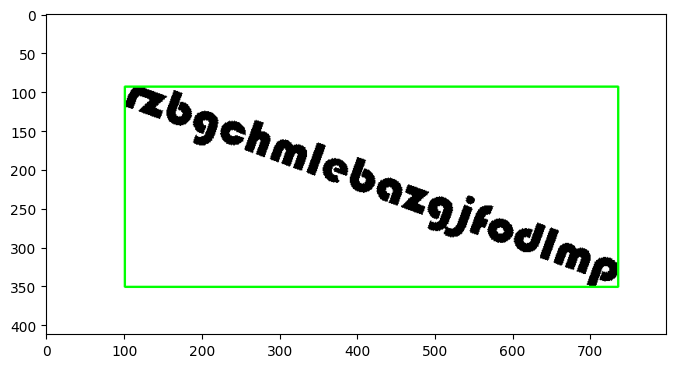

In [48]:
x_min, y_min, x_max, y_max, increasing_rotation = identify_corners(test_img)
print(f"Top-left corner: ({x_min}, {y_min})")
print(f"Bottom-right corner: ({x_max}, {y_max})")
print(f"Increasing rotation: {increasing_rotation}")

img_with_bbox = cv.cvtColor(test_img, cv.COLOR_GRAY2BGR)
cv.rectangle(img_with_bbox, (x_min, y_min), (x_max, y_max), (0, 255, 0), 2)

# Display the image with bounding box
fig = plt.figure(figsize=(8, 8))
plt.imshow(cv.cvtColor(img_with_bbox, cv.COLOR_BGR2RGB))
plt.show()

## 2) Find text orientation angle

### 2.1) Find rotation angle by means of the diagonal


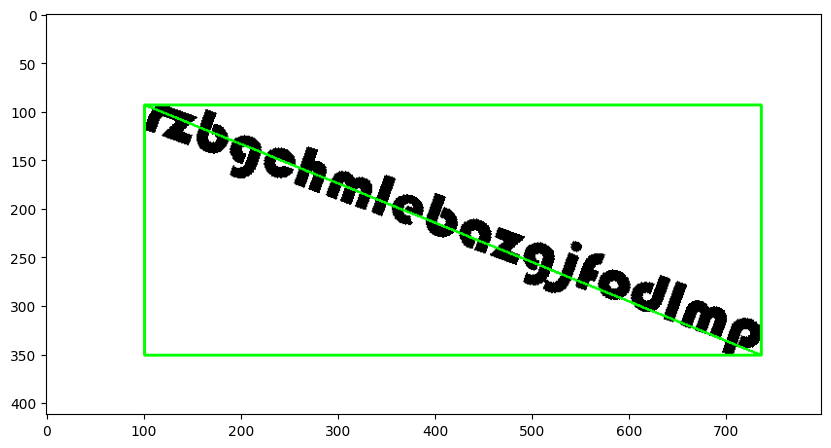

In [49]:
img_with_bbox_diag = img_with_bbox.copy()

# Draw the diagonal based on the text direction
if increasing_rotation:
    # Bottom-left (x_min, y_max) to Top-right (x_max, y_min)
    cv.line(img_with_bbox_diag, (x_min, y_max), (x_max, y_min), (0, 255, 0), 2)
else:
    # Top-left (x_min, y_min) to Bottom-right (x_max, y_max)
    cv.line(img_with_bbox_diag, (x_min, y_min), (x_max, y_max), (0, 255, 0), 2)

# Display the image with diagonal
fig = plt.figure(figsize=(10, 10))
plt.imshow(cv.cvtColor(img_with_bbox_diag, cv.COLOR_BGR2RGB))
plt.show()

In [50]:
def compute_rotation_angle(x_min, y_min, x_max, y_max, orientation):
    if orientation:
        # Diagonal from B-L (x_min, y_min) to T-R (x_max, y_max)
        delta_y = y_max - y_min
        delta_x = x_max - x_min
    else:
        # Diagonal from T-L (x_min, y_max) to B-R (x_max, y_min)
        delta_y = y_min - y_max
        delta_x = x_max - x_min

    # Calculate the angle in radians
    angle_rad = math.atan2(delta_y, delta_x)

    # Convert to degrees
    angle_deg = math.degrees(angle_rad)

    return -angle_deg

diag_angle = compute_rotation_angle(x_min, y_min, x_max, y_max, increasing_rotation)
print(f"Rotation Angle: {diag_angle:.2f} degrees")

Rotation Angle: 22.03 degrees


As we can easily observe, the direction indicated by the diagonal of the large bounding box is often a **rough approximation** of the actual orientation. Let's tackle this sub-task with a more refined engineering approach.

### 2.2) Find orientation angle using linear regression

Let's infer it using a geometric approach: first, we identify two so-called '**density centers**'—points analogous to centroids—that often represent the first and last letters. This step helps account for directional misalignments caused by the varying heights of these two letters.

In [51]:
#@title utils
def find_center_of_density_for_column(img, col, y_min, y_max):
    """
    Find the center of density for a given column (for foreground pixels).
    - img: binary image (foreground=0, background=255)
    - col: column index
    - y_min: Top boundary of the bounding box
    - y_max: Bottom boundary of the bounding box
    - returning: the row position of the center of density for the column
    """
    rows = np.where(img[y_min:y_max+1, col] == 0)[0]  # Find foreground pixels
    if len(rows) > 0:
        return np.mean(rows) + y_min  # Adjust to global coordinates
    return None

def scan_bbox_for_first_last_letters(img, bbox, beam_size):
    """
    Scan the bounding box twice (left-to-right and right-to-left) to identify
    the first and last letters using a beam of columns.
    - bbox: the large bounding box coordinates (x_min, y_min, x_max, y_max)
    - beam_size: the size of the beam (number of columns to scan at once)
    - returning: (first_letter_info, last_letter_info)
    """
    x_min, y_min, x_max, y_max = bbox

    # Initialize variables to store the first and last letter information
    first_col = None
    last_col = None
    first_letter_center = None
    last_letter_center = None

    # 1. Scan left to right (find the first letter)
    for start_col in range(x_min, x_max, beam_size):
        end_col = min(start_col + beam_size - 1, x_max)
        for col in range(start_col, end_col + 1):
            center = find_center_of_density_for_column(img, col, y_min, y_max)
            if center is not None:
                first_col = col  # First column with foreground
                first_letter_center = center
                break  # Exit after finding the first letter

    # 2. Scan right to left (find the last letter)
    for start_col in range(x_max, x_min, -beam_size):
        end_col = max(start_col - beam_size + 1, x_min)
        for col in range(start_col, end_col - 1, -1):
            center = find_center_of_density_for_column(img, col, y_min, y_max)
            if center is not None:
                last_col = col  # Last column with foreground
                last_letter_center = center
                break  # Exit after finding the last letter

    if first_col is None or last_col is None:
        raise ValueError("Unable to detect the first and last letters.")

    return (first_col, first_letter_center), (last_col, last_letter_center)

def visualize_orientation(img, center_left, center_right, angle):
    """
    Visualize the centers of the first and last letters, and the orientation line.
    """
    fig = plt.figure(figsize=(10, 10))
    plt.imshow(img, cmap='gray', origin='upper')

    # Plot centers of the first and last letters
    plt.scatter([center_left[0], center_right[0]], [center_left[1], center_right[1]], color='red', label='Centers of first/last letters')

    # Draw the orientation line
    x = np.array([center_left[0], center_right[0]])
    y = np.array([center_left[1], center_right[1]])
    plt.plot(x, y, color='blue', label=f'Orientation line ({angle:.2f}°)')

    plt.legend()
    plt.show()

In [52]:
bbox = (x_min, y_min, x_max, y_max)

#### 2.2.1) Font size awareness

Most of the time, the first approach is the most naive, as in this case.  
Here, I compute the orientation angle by considering the bounding box's shape to address **font size variability**.

Rotation angle: 20.60 degrees


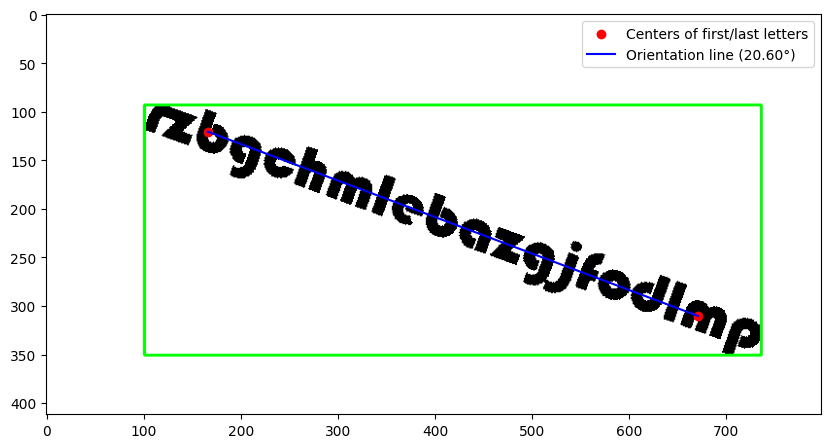

In [53]:
def compute_orientation(img, bbox, adaptive_beam_ratio):
    """
    Compute the orientation of the text based on the first and last letters.
    - img: the binary image (foreground=0, background=255)
    - bbox: the bounding box (x_min, y_min, x_max, y_max)
    - adaptive_beam_ratio: the ratio of bounding box width to compute beam size
    - returning: the orientation angle in degrees
    """
    x_min, y_min, x_max, y_max = bbox
    bbox_width = x_max - x_min + 1

    # Compute adaptive beam size
    beam_size = max(1, int(adaptive_beam_ratio * bbox_width))  # At least 1 column

    # Scan the bounding box to find first and last letters
    first_letter, last_letter = scan_bbox_for_first_last_letters(img, bbox, beam_size)

    # First and last letter coordinates (column, center of density)
    x1, y1 = first_letter
    x2, y2 = last_letter

    # Compute the slope (m) of the line between the two centers
    if x1 == x2:
        angle = 90.0  # Vertical line, handle as special case
    else:
        m = (y2 - y1) / (x2 - x1)
        # Compute the angle using the arctangent of the slope
        angle = np.arctan(m) * (180 / np.pi)  # Convert to degrees

    return angle, first_letter, last_letter

angle, first_letter, last_letter = compute_orientation(test_img, bbox, adaptive_beam_ratio=0.3)
print(f"Rotation angle: {angle:.2f} degrees")

# Visualize the result
visualize_orientation(img_with_bbox, first_letter, last_letter, angle)

#### 2.2.2) Letter thickness awareness

Here I try another approach that considers **letter thickness**, which can heavily influence the computation of the two density centers.

This approach first compute the average thickness of the letters, and then use it to dynamically calculate the 'beam' size, basically deciding how many columns to scan.

Orientation angle: 21.76 degrees


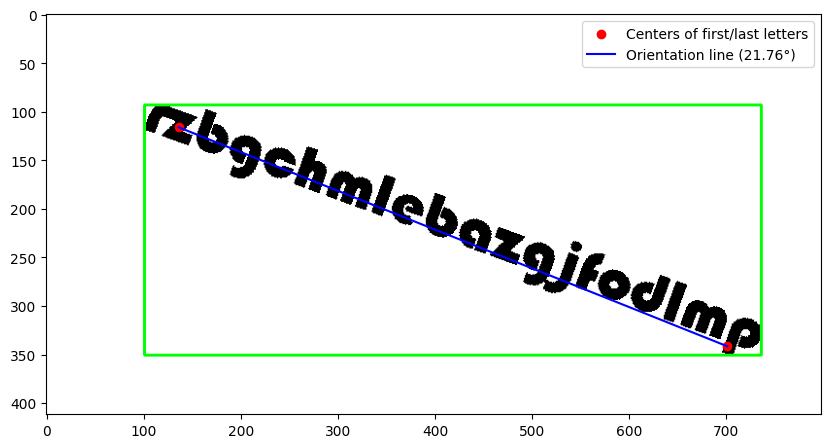

In [54]:
def estimate_letter_thickness(img, bbox):
    """
    Estimate the average letter thickness (stroke width) within the bounding box.
    - returning: Estimated letter thickness (average number of foreground pixels per column)
    """
    x_min, y_min, x_max, y_max = bbox
    thicknesses = []

    # Iterate over columns in the bounding box
    for col in range(x_min, x_max + 1):
        rows = np.where(img[y_min:y_max + 1, col] == 0)[0]  # Foreground pixels
        if len(rows) > 0:
            thicknesses.append(len(rows))  # Count of foreground pixels in this column

    if len(thicknesses) == 0:
        raise ValueError("No foreground pixels found in the bounding box.")

    return np.mean(thicknesses)  # Average thickness


def compute_orientation_with_thickness(img, bbox, thickness_scale=3):
    """
    Compute the orientation of the text considering letter thickness.
    - thickness_scale: Scaling factor for beam size based on letter thickness
    - returning: Orientation angle in degrees
    """
    # Estimate letter thickness
    avg_thickness = estimate_letter_thickness(img, bbox)

    # Set dynamic beam size based on letter thickness
    beam_size = max(1, int(thickness_scale * avg_thickness))

    # Scan the bounding box to find first and last letters
    first_letter, last_letter = scan_bbox_for_first_last_letters(img, bbox, beam_size)

    # First and last letter coordinates (column, center of density)
    x1, y1 = first_letter
    x2, y2 = last_letter

    # Compute the slope (m) of the line between the two centers
    if x1 == x2:
        angle = 90.0  # Vertical line, handle as special case
    else:
        m = (y2 - y1) / (x2 - x1)
        # Compute the angle using the arctangent of the slope
        angle = np.arctan(m) * (180 / np.pi)  # Convert to degrees

    return angle, first_letter, last_letter, beam_size, avg_thickness

angle, first_letter, last_letter, beam_size, avg_thickness = compute_orientation_with_thickness(test_img, bbox)
print(f"Orientation angle: {angle:.2f} degrees")
#print(f"First letter center: {first_letter}")
#print(f"Last letter center: {last_letter}")
#print(f"Beam size used: {beam_size}")
#print(f"Estimated letter thickness: {avg_thickness:.2f}")

# Visualize the result
visualize_orientation(img_with_bbox, first_letter, last_letter, angle)

#### 2.2.3) Font size & thickness: merged approach

Below I merge the two approaches presented above, in order to taking into account as many sources of variability as possible.

In [55]:
def compute_dynamic_beam_size(img, bbox, thickness_scale=3, bbox_scale=0.1):
    """
    Compute an adaptive beam size based on letter thickness and bounding box size.
    :param img: Binary image (foreground=0, background=255)
    :param bbox: Bounding box (x_min, y_min, x_max, y_max)
    :param thickness_scale: Scaling factor for letter thickness
    :param bbox_scale: Scaling factor for bounding box width
    :return: Dynamic beam size
    """
    # Estimate letter thickness
    avg_thickness = estimate_letter_thickness(img, bbox)

    # Calculate bounding box width
    x_min, _, x_max, _ = bbox
    bbox_width = x_max - x_min + 1

    # Compute dynamic beam size
    beam_size = int(thickness_scale * avg_thickness + bbox_scale * bbox_width)
    return max(1, beam_size)  # Ensure the beam size is at least 1


def compute_orientation_adaptive(img, bbox, thickness_scale=3, bbox_scale=0.1):
    """
    Compute the orientation of the text with adaptive beam size.
    :param img: Binary image (foreground=0, background=255)
    :param bbox: Bounding box (x_min, y_min, x_max, y_max)
    :param thickness_scale: Scaling factor for letter thickness
    :param bbox_scale: Scaling factor for bounding box width
    :return: Orientation angle in degrees, first/last letter centers, and beam size
    """
    # Compute dynamic beam size
    beam_size = compute_dynamic_beam_size(img, bbox, thickness_scale, bbox_scale)

    # Find first and last letters using adaptive beam size
    first_letter, last_letter = scan_bbox_for_first_last_letters(img, bbox, beam_size)

    # First and last letter coordinates (column, center of density)
    x1, y1 = first_letter
    x2, y2 = last_letter

    # Compute the slope (m) of the line between the two centers
    if x1 == x2:
        angle = 90.0  # Vertical line, handle as special case
    else:
        m = (y2 - y1) / (x2 - x1)
        # Compute the angle using the arctangent of the slope
        angle = np.arctan(m) * (180 / np.pi)  # Convert to degrees

    return angle, first_letter, last_letter

Orientation angle: 18.83 degrees


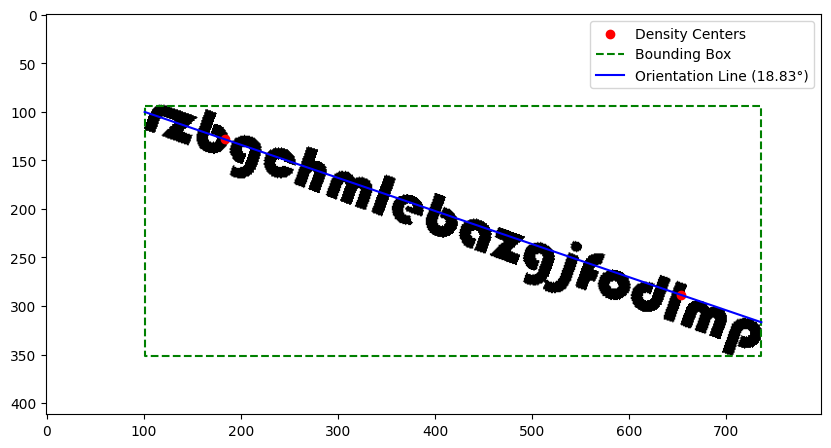

In [56]:
#@title connecting points, just for visualization purposes
def find_line_bbox_intersections(x1, y1, x2, y2, bbox):
    """
    Find the intersection points of a line passing through (x1, y1) and (x2, y2) with a bounding box
    - x1, y1: the first density center coordinates
    - x2, y2: the last density center coordinates
    - returning: a list of intersection points (x, y) with bbox edges
    """
    x_min, y_min, x_max, y_max = bbox

    # Compute the slope (m) and intercept (c)
    if x1 == x2:  # Vertical line
        m = None
        c = None
    else:
        m = (y2 - y1) / (x2 - x1)
        c = y1 - m * x1

    # Intersection points
    intersections = []

    # Check intersection with each bounding box edge
    if m is not None:  # For non-vertical lines
        # Intersection with y = y_min
        x_at_y_min = (y_min - c) / m if m != 0 else x1
        if x_min <= x_at_y_min <= x_max:
            intersections.append((x_at_y_min, y_min))

        # Intersection with y = y_max
        x_at_y_max = (y_max - c) / m if m != 0 else x1
        if x_min <= x_at_y_max <= x_max:
            intersections.append((x_at_y_max, y_max))

    # Intersection with x = x_min
    y_at_x_min = m * x_min + c if m is not None else y1
    if y_min <= y_at_x_min <= y_max:
        intersections.append((x_min, y_at_x_min))

    # Intersection with x = x_max
    y_at_x_max = m * x_max + c if m is not None else y1
    if y_min <= y_at_x_max <= y_max:
        intersections.append((x_max, y_at_x_max))

    return intersections


def visualize_full_orientation(img, center_left, center_right, angle, bbox):
    """
    Visualize the orientation line extended to intersect the bounding box.
    """
    x_min, y_min, x_max, y_max = bbox
    intersections = find_line_bbox_intersections(center_left[0], center_left[1],
                                                 center_right[0], center_right[1], bbox)
    fig=plt.figure(figsize=(10, 10))
    plt.imshow(img, cmap='gray', origin='upper')

    # Plot centers of the first and last letters
    plt.scatter([center_left[0], center_right[0]], [center_left[1], center_right[1]],
                color='red', label='Density Centers')

    # Plot bounding box
    plt.plot([x_min, x_max, x_max, x_min, x_min], [y_min, y_min, y_max, y_max, y_min],
             color='green', linestyle='--', label='Bounding Box')

    # Plot the orientation line (extended through the bbox)
    if len(intersections) >= 2:
        p1, p2 = intersections[:2]
        plt.plot([p1[0], p2[0]], [p1[1], p2[1]], color='blue', label=f'Orientation Line ({angle:.2f}°)')

    plt.legend()
    plt.show()

angle, first_letter, last_letter = compute_orientation_adaptive(test_img, bbox)
print(f"Orientation angle: {angle:.2f} degrees")
visualize_full_orientation(test_img, first_letter, last_letter, angle, bbox)

## 3) Detecting letters
As said before, we slide a virtual window along the orientation computed before. Practically speaking, we scan column by column within the bounding box, finding

With the following method, we add a post-processing technique that should merge areas only if one of them is small (to handle cases of j's and i's, where letters present discontinuities)

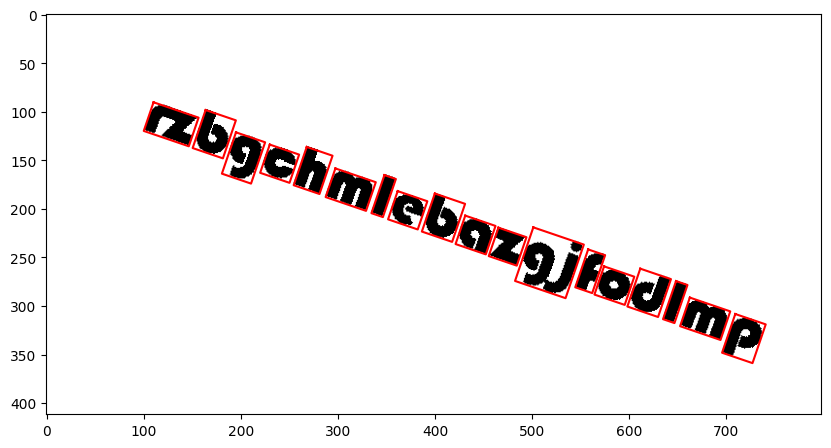

In [57]:
def detect_letters(img, bbox, angle, area_threshold=200, distance_threshold=10):
    """
    Detect individual letters with oriented bounding boxes, including handling small disconnected components.
    - img: the binary image
    - bbox: the big bounding box (x_min, y_min, x_max, y_max)
    - angle: the orientation angle in degrees
    - area_threshold: the threshold area for small components (e.g., dots of 'i' or 'j')
    - distance_threshold: the maximum distance between components to be considered part of the same letter
    - returning: a list of oriented bounding boxes [(x1, y1, x2, y2, x3, y3, x4, y4)]
    """
    x_min, y_min, x_max, y_max = bbox
    letters = []

    # Convert angle to radians
    angle_radians = np.deg2rad(angle)
    tan_angle = np.tan(angle_radians)

    visited = np.zeros_like(img, dtype=bool)
    components = []

    # Scan column by column within the bounding box
    for x in range(x_min, x_max):
        # Adjust vertical offset for the current column, following the given orientation
        y_offset = int((x - x_min) * tan_angle)
        adjusted_y_min = max(y_min + y_offset, 0)
        adjusted_y_max = min(y_max + y_offset, img.shape[0] - 1)

        for y in range(adjusted_y_min, adjusted_y_max + 1):
            if img[y, x] == 0 and not visited[y, x]:  # Unvisited black pixel
                # Perform a flood-fill to extract the connected component
                component_pixels = flood_fill(img, x, y, visited)

                # Store the component if it has pixels
                if component_pixels:
                    components.append(component_pixels)

    # Post-processing: merge small disconnected components based on area
    merged_components = merge_small_components(components, img, angle, area_threshold, distance_threshold)

    # Compute oriented bounding boxes for all components
    for component in merged_components:
        if component:
            obb = compute_oriented_bbox(component, angle)
            letters.append(obb)

    return letters

def flood_fill(img, x, y, visited):
    """
    Perform flood-fill algorithm to extract a connected component of foreground pixels,
    ideally finding a whole letter or at least one of its parts
    - img: the binary image
    - x, y: the starting pixel
    - visited: an array marking visited pixels
    - returning: a list of (x, y) coordinates of the connected component
    """
    stack = [(x, y)]
    component = []

    while stack:
        cx, cy = stack.pop()
        if 0 <= cx < img.shape[1] and 0 <= cy < img.shape[0] and not visited[cy, cx] and img[cy, cx] == 0:
            visited[cy, cx] = True
            component.append((cx, cy))
            # Add neighbors to the stack
            stack.extend([(cx+1, cy), (cx-1, cy), (cx, cy+1), (cx, cy-1)])

    return component

def merge_small_components(components, img, angle, area_threshold, distance_threshold):
    """
    Merge small components based on area and proximity.
    - param components: a list of detected components (each a list of (x, y) coordinates)
    - img: the binary image
    - angle: the orientation angle in degrees
    - area_threshold: the minimum area to be considered a small component
    - distance_threshold: the maximum distance between components to be considered part of the same letter
    - returning: a list of merged components
    """
    merged = []
    visited = [False] * len(components)

    def distance(c1, c2):
        """ Compute the distance between two components. """
        min_distance = float('inf')
        for (x1, y1) in c1:
            for (x2, y2) in c2:
                dist = np.sqrt((x1 - x2)**2 + (y1 - y2)**2)
                min_distance = min(min_distance, dist)
        return min_distance

    for i, comp1 in enumerate(components):
        if visited[i]:
            continue
        area1 = len(comp1)
        merged_component = comp1
        visited[i] = True

        for j, comp2 in enumerate(components):
            if i != j and not visited[j]:
                area2 = len(comp2)
                if area2 < area_threshold and distance(comp1, comp2) < distance_threshold:
                    # Merge small component with the larger one if they are close enough
                    merged_component += comp2
                    visited[j] = True
        merged.append(merged_component)

    return merged

def compute_oriented_bbox(pixels, angle):
    """
    Compute the oriented bounding box for a set of connected pixels.
    - pixels: a list of (x, y) coordinates of the connected component
    - returning: an oriented bounding box [(x1, y1), (x2, y2), (x3, y3), (x4, y4)]
    """
    angle_radians = np.deg2rad(angle)
    cos_angle = np.cos(angle_radians)
    sin_angle = np.sin(angle_radians)

    # Rotate the pixels to align with the horizontal axis
    rotated_pixels = [(x * cos_angle + y * sin_angle, -x * sin_angle + y * cos_angle) for x, y in pixels]

    # Find the axis-aligned bounding box in the rotated space
    x_coords, y_coords = zip(*rotated_pixels)
    x_min, x_max = min(x_coords), max(x_coords)
    y_min, y_max = min(y_coords), max(y_coords)

    # Define the corners of the bounding box in rotated space
    rotated_bbox = [
        (x_min, y_min), (x_max, y_min),
        (x_max, y_max), (x_min, y_max)
    ]

    # Rotate the bounding box back to the original orientation
    bbox = [(x * cos_angle - y * sin_angle, x * sin_angle + y * cos_angle) for x, y in rotated_bbox]
    return bbox

def visualize_oriented_bboxes(img, bboxes):
    fig = plt.figure(figsize=(10, 10))
    plt.imshow(img, cmap='gray', origin='upper')
    for bbox in bboxes:
        x_coords, y_coords = zip(*bbox + [bbox[0]])  # Close the polygon
        plt.plot(x_coords, y_coords, color='red')
    plt.show()

# Find letters
letters = detect_letters(test_img, bbox, angle)

# Visualize oriented bounding boxes
visualize_oriented_bboxes(test_img, letters)

As we can see, given the assumptions made earlier, the type of text above, with its specific font structure, prevents accurate letter detection due to issues with the contiguity of different letters.

## 4) Produce json coordinates

In [58]:
def calculate_bbox_properties(bbox):
    """
    Calculate the center, angle, height, and width of an oriented bounding box.
    - bbox: a list of 4 corner points [(x1, y1), (x2, y2), (x3, y3), (x4, y4)]
    - returning: a dictionary with center_x, center_y, angle, height, and width
    """
    # Convert to NumPy array for easier manipulation
    bbox = np.array(bbox)

    # Calculate the center
    center_x = np.mean(bbox[:, 0])
    center_y = np.mean(bbox[:, 1])

    # Calculate the width and height
    edge1 = np.linalg.norm(bbox[0] - bbox[1])  # Distance between corner 1 and 2
    edge2 = np.linalg.norm(bbox[1] - bbox[2])  # Distance between corner 2 and 3
    width, height = sorted([edge1, edge2])  # Ensure width is smaller dimension

    # Calculate the angle (in radians)
    dx, dy = bbox[1] - bbox[0]  # Vector for one edge
    angle = np.arctan2(dy, dx)  # Orientation angle

    return {
        "center_x": round(center_x, 3),
        "center_y": round(center_y, 3),
        "angle": round(angle, 8),
        "width": round(width, 1),
        "height": round(height, 1)
    }

## 5) Automatize all

Visualizing detected letters for 000.png


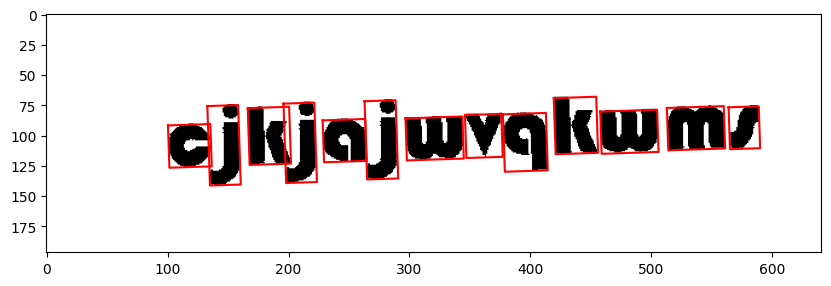


Visualizing detected letters for 002.png


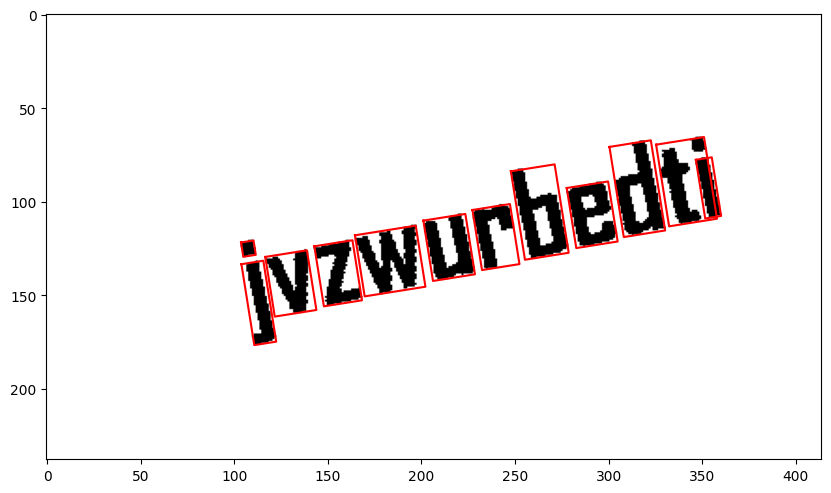


Visualizing detected letters for 003.png


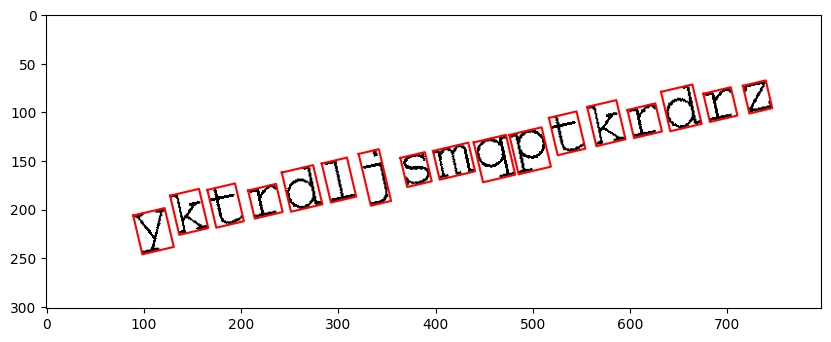

KeyboardInterrupt: 

In [59]:
import json

output_data = []

for img_file, img in zip(imgs_file, imgs):
  output_dict = {img_file: []}
  x_min, y_min, x_max, y_max, increasing_rotation = identify_corners(img)
  bbox = (x_min, y_min, x_max, y_max)
  angle, first_letter, last_letter = compute_orientation_adaptive(img, bbox)
  letters = detect_letters(img, bbox, angle)

  # Visualize detected letters for the current image
  print(f"Visualizing detected letters for {img_file}")
  visualize_oriented_bboxes(img, letters)
  print()

  # Append to the output data
  output_data.append(output_dict)

  for letter in letters:
    letter_properties = calculate_bbox_properties(letter)
    output_dict[img_file].append(letter_properties)

# Save to a JSON file
output_json_file = "detected_letters.json"
with open(output_json_file, "w") as json_file:
    json.dump(output_data, json_file, indent=4)

print(f"Detection results have been saved to {output_json_file}")
#print(output_dict)

### 6) Comments

This challenge was highly demanding!  
Working at the pixel level with the constraint of not utilizing built-in image processing techniques proved to be the main difficulty.  

#### Complexity Analysis
Regarding my solution: it has both flaws and strengths. Complexity improvements are necessary, as:
- The repeated column-wise scanning takes \(O(W \cdot H)\),
- The flood-fill algorithm operates at \(O(W \cdot H)\) for each detected component,
- The merging method has a total complexity of \(O(N^2 + N)\), and
- The oriented bounding box computation has an overall complexity of \(O(N \cdot n)\),  

where:  
- \(N\) is the number of components,  
- \(n\) is the number of pixels in each component,  
- \(H\) is the height of the bounding box, and  
- \(W\) is its width.  

#### Key Challenges
1. **Gradient-Based Edge Detection**  
   Due to the computational cost, I avoided gradient-based methods to emulate techniques like the built-in Canny detector. These methods require significant computational resources.

2. **Handling Letter Discontinuities**  
   Managing disconnected parts of letters, such as the dots in "i" and "j," or letters with slight disconnections caused by font properties, posed a significant challenge due to the flood-fill-based approach.

#### Potential Enhancements
This approach can be improved in several ways:
- **Exploiting Domain Knowledge:** Incorporating font information to aid in detection and merging of components.  
- **Optimizing the Flood-Fill Algorithm:** Developing a more efficient strategy for component merging to reduce computational complexity.  
- **Using PCA for Better Bounding Boxes:** Applying Principal Component Analysis (PCA) to determine the major and minor axes of a component, which would allow for more accurate oriented bounding box estimation without the need to rotate every pixel individually.  
